In [3]:
'''

Author: Luca Pedrelli
'''

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

from matplotlib import pylab

import keras
import numpy as np

np.random.seed(7)

# Mean Squared Error
def MSE(X,Y):
    return  np.mean((X-Y)**2)

In [4]:
# load dataset
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 4s 0us/step


5


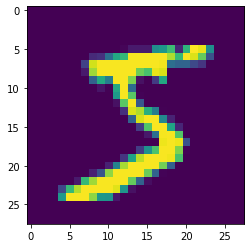

In [9]:
pylab.imshow(x_train[0,:,:])
print (y_train[0,])

0


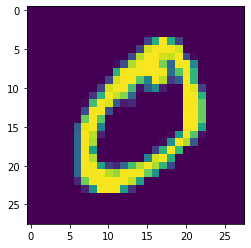

In [10]:
pylab.imshow(x_train[1,:,:])
print (y_train[1,])

In [7]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [11]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]*x_test.shape[2]))

In [12]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [13]:
inputs = np.concatenate([x_train, x_test], axis=0).T.astype('float32')
targets = np.concatenate([y_train, y_test], axis=0).T.astype('float32')

In [14]:
inputs.shape, targets.shape

((784, 70000), (70000,))

In [15]:
targets = keras.utils.to_categorical(targets, num_classes=None).T

In [16]:
TR_indexes = range(0,50)
VL_indexes = range(50,60)
TS_indexes = range(60,70)
Full_TR_indexes = list(TR_indexes) + list(VL_indexes)
Ninputs = inputs.shape[0]
Noutputs = targets.shape[0]


In [26]:
# Create network: initialize weights from [-1,1]
Nlayers = 2
Neurons = 100

W = []
layers = range(Nlayers)
for l in layers:
    if len(layers) == 1:
        W.append(np.random.uniform(-1,1, (Noutputs, Ninputs+1)))
    elif l == 0:
        W.append(np.random.uniform(-1,1, (Neurons, Ninputs+1)))
    elif l < Nlayers-1:
        W.append(np.random.uniform(-1,1, (Neurons, Neurons+1)))
    else:
        W.append(np.random.uniform(-1,1, (Noutputs, Neurons+1))) 

$O^{(L)} = \mathbf{tanh}(W_{L} O^{(l-1)})$

In [37]:
# Compute layers outputs
def forward_pass(W, inputs):
    otuputs = []
    for l in range(len(W)):
        if l==len(W)-1: #last layer 
            otuputs.append(W[l][:,:-1].dot(inputs) + np.expand_dims(W[l][:,-1], axis=1)) #W*input+bias
        else:
            otuputs.append(np.tanh(W[l][:,:-1].dot(inputs) + np.expand_dims(W[l][:,-1], axis=1)))
            
        inputs = otuputs[-1]
  
    return otuputs

In [38]:
# Compute a gradient descent pass on a sample input
def backward_pass(W, sample_input, single_target):

    outputs = forward_pass(W, sample_input)

    deltas = []
    dWs = []

    for l in reversed(range(len(W))):
        delta = np.zeros(W[l].shape[0])
        dW    = np.zeros(W[l].shape)

        for k in range(W[l].shape[0]):
            if l == Nlayers-1:       
                delta[k] = (single_target[k,0] - outputs[l][k,0])   # y - output

            else:
                delta_kk = 0.0
                for z in range(deltas[-1].shape[0]):
                    delta_kk = delta_kk + deltas[-1][z] * W[l+1][z,k]

                delta[k] = delta_kk * (1 - outputs[l][k,0]**2)

            for i in range(W[l].shape[1]-1): # without bias
                if l==0:
                    dW[k,i] = delta[k] * sample_input[i,0]
                else:
                    dW[k,i] = delta[k] * outputs[l-1][i,0]

            dW[k,-1] = dW[k,-1] + W[l][k,-1] # add bias

        deltas.append(delta)
        dWs.append(dW)
    
    return dWs


In [39]:
# leraning rate
lr = 0.0001
epochs = 20
errors = []

for epoch in range(epochs):
    print(epoch)
    for p in Full_TR_indexes:
        dWs = backward_pass(W, inputs[:,p:p+1], targets[:,p:p+1])
        for l in reversed(range(len(W))):
            W[Nlayers-1-l] = W[Nlayers-1-l] + lr*dWs[l]

    outputs = forward_pass(W, inputs)[-1]
    errors.append(MSE(outputs[:, Full_TR_indexes], targets[:, Full_TR_indexes]))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [40]:
inputs[:,p:p+1].shape

(784, 1)

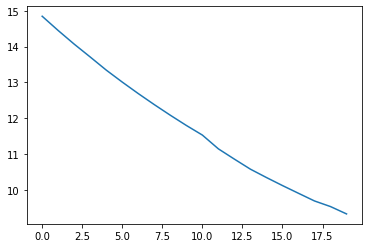

In [41]:
# Plot Learning Curve
pylab.plot(range(len(errors)),errors)

In [42]:
errors

[14.846431918510774,
 14.448665776439693,
 14.06899584503956,
 13.710372837754942,
 13.345472794617203,
 13.011361229323592,
 12.690985119720562,
 12.38329343317468,
 12.087538818982567,
 11.80304897539783,
 11.534928983708951,
 11.150776114486993,
 10.864043548814138,
 10.584268626842771,
 10.351639609887338,
 10.127881461529817,
 9.912345816098684,
 9.698494237317107,
 9.542062335197416,
 9.337424973541742]

In [43]:
# Training Loss Error
MSE(forward_pass(W, inputs)[-1][:,Full_TR_indexes],targets[:,Full_TR_indexes])

9.337424973541742

In [44]:
#Train accuracy
np.mean(np.argmax(forward_pass(W, inputs)[-1][:,Full_TR_indexes], axis=0)==np.argmax(targets[:,Full_TR_indexes], axis=0))

0.13333333333333333